In [10]:
# %% 0) Imports & FOXES engine config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV
import foxes.input.farm_layout as layout
from foxes import algorithms

# Force FOXES to use threads and only 1 worker (light on resources)
os.environ["FOXES_ENGINE"]  = "threads"
os.environ["FOXES_N_PROCS"] = "1"

# Helpers
from customFunctions import setup_algo, compute_yield

# %% 1) Load & prepare ERA5 data (2006)
era5 = (
    pd.read_csv("reanalysis.csv", index_col=0, parse_dates=True)
      .rename(columns={"WS100":"WS","WD100":"WD"})
      .replace(-999, np.nan)
      .resample("h").mean()
)
era5.index = pd.to_datetime(era5.index)
era5 = era5.loc["2006-01-01":"2006-12-31"]
if "TI" not in era5.columns:
    era5["TI"] = 0.10

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8760 states for 1 turbines
SingleChunkEngine: Running single chunk calculation for 8760 states


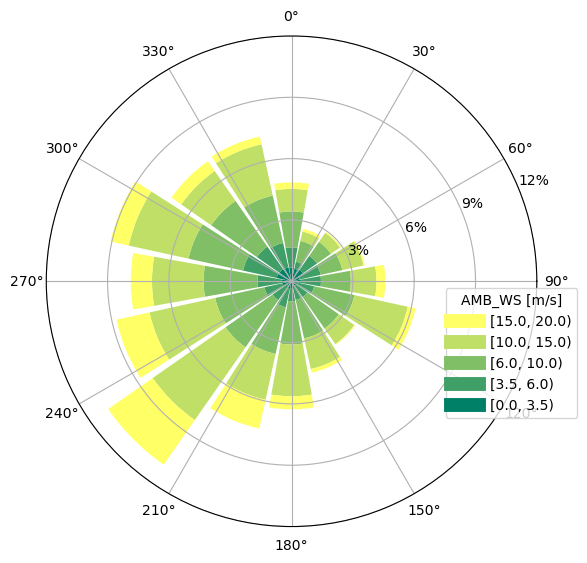

In [11]:
# %% 2) Build FOXES states and plot a windrose
states = foxes.input.states.Timeseries(
    data_source=era5,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS:"WS", FV.WD:"WD", FV.TI:"TI"},
    fixed_vars={FV.RHO:1.225},
)
ros = foxes.output.StatesRosePlotOutput(states, point=[0,0,100])
ros.get_figure(16, FV.AMB_WS, [0,3.5,6,10,15,20], figsize=(6,6))
plt.tight_layout()
plt.show()


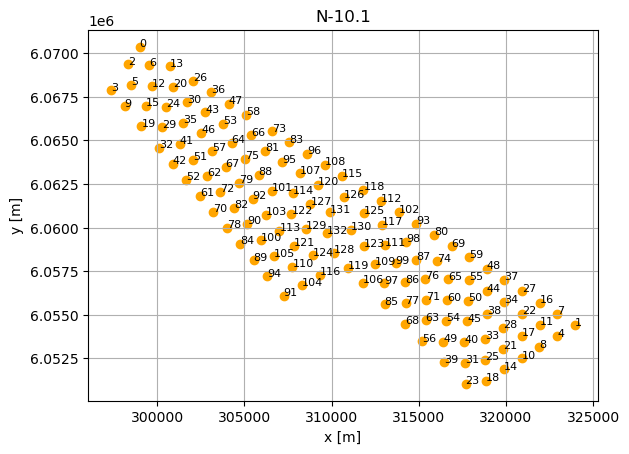

In [12]:
# %% 3) Create & display the farm layout for N-10.1
farm = foxes.WindFarm(name="N-10.1")
layout_df = pd.read_csv(
    "turbine-info/coordinates/area_of_interest/layout-N-10.1.geom.csv",
    index_col=None
)
layout.add_from_csv(farm, layout_df, turbine_models=["NREL5MW"], verbosity=0)
# Corrected section
layout_fig = foxes.output.FarmLayoutOutput(farm).get_figure()
fig = layout_fig.figure  # Get the Figure from the Axes object
fig.tight_layout()
plt.show()



=== TASK 4: Base Case ===
Turbine 0, T0: xy=(299005.80, 6070368.13), DTU10MW
Turbine 1, T1: xy=(298349.95, 6069364.01), DTU10MW
Turbine 2, T2: xy=(299546.60, 6069298.19), DTU10MW
Turbine 3, T3: xy=(300744.40, 6069255.93), DTU10MW
Turbine 4, T4: xy=(302075.57, 6068404.37), DTU10MW
Turbine 5, T5: xy=(298529.18, 6068179.05), DTU10MW
Turbine 6, T6: xy=(299725.82, 6068113.23), DTU10MW
Turbine 7, T7: xy=(300923.62, 6068070.97), DTU10MW
Turbine 8, T8: xy=(297371.96, 6067866.68), DTU10MW
Turbine 9, T9: xy=(303085.54, 6067758.28), DTU10MW
Turbine 10, T10: xy=(301715.50, 6067171.26), DTU10MW
Turbine 11, T11: xy=(304095.51, 6067112.19), DTU10MW
Turbine 12, T12: xy=(299341.24, 6066978.00), DTU10MW
Turbine 13, T13: xy=(298142.83, 6066947.93), DTU10MW
Turbine 14, T14: xy=(300539.04, 6066935.73), DTU10MW
Turbine 15, T15: xy=(302771.25, 6066601.55), DTU10MW
Turbine 16, T16: xy=(305105.47, 6066466.11), DTU10MW
Turbine 17, T17: xy=(301478.71, 6065995.11), DTU10MW
Turbine 18, T18: xy=(303781.22, 6065955.

100%|██████████| 12/12 [01:00<00:00,  5.06s/it]


Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results
Farm ambient power [MW]: 795.9
Farm net power     [MW]: 686.8
Farm efficiency        : 0.863
Annual yield      [GWh]: 6015.99

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8760 states for 133 turbines
ProcessEngine: Computing 12 chunks using 12 processes


100%|██████████| 12/12 [01:00<00:00,  5.03s/it]


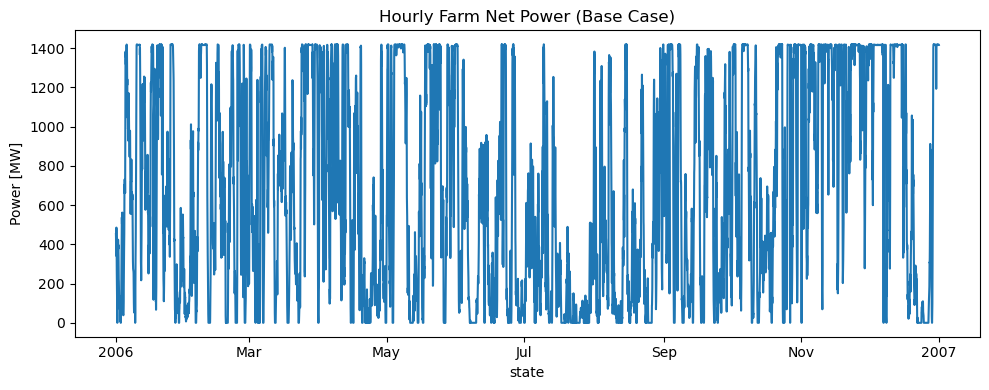

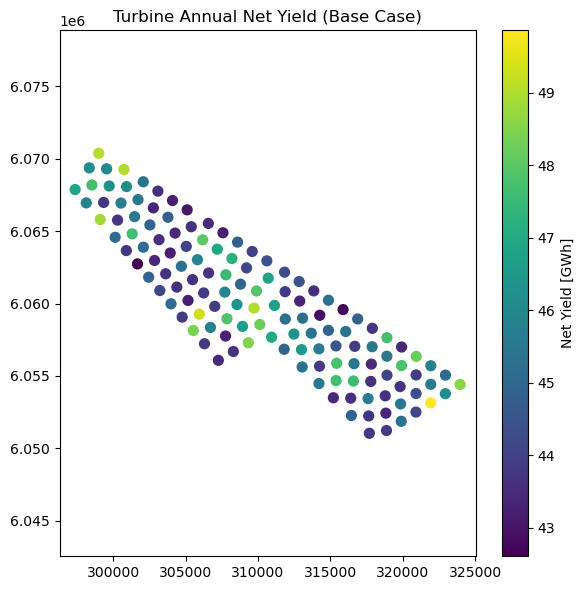

In [13]:
# %% 4) TASK 4 — Base case (internal wakes only)
print("=== TASK 4: Base Case ===")
algo_base = setup_algo(
    wind_data=era5,
    windfarm_name="N-10.1",
    wake_models=["Bastankhah2014_quadratic_ka02"]
)
stats_base, summ_base = compute_yield(algo_base)

print(f"Farm ambient power [MW]: {summ_base['farm_ambient_power_MW']:.1f}")
print(f"Farm net power     [MW]: {summ_base['farm_net_power_MW']:.1f}")
print(f"Farm efficiency        : {summ_base['farm_efficiency']:.3f}")
print(f"Annual yield      [GWh]: {summ_base['annual_yield_GWh']:.2f}\n")

# Time series of farm net power
results_base = algo_base.calc_farm(calc_parameters={"chunk_size_states":1000})
ts_power = results_base["P"].sum(dim="turbine") / 1000  # MW

plt.figure(figsize=(10,4))
ts_power.plot()
plt.title("Hourly Farm Net Power (Base Case)")
plt.ylabel("Power [MW]")
plt.tight_layout()
plt.show()

# Spatial map of turbine yields
pos = layout_df[["x","y"]].values
yields_base = stats_base["Net Yield     [GWh]"].values

plt.figure(figsize=(6,6))
sc = plt.scatter(pos[:,0], pos[:,1], c=yields_base, cmap="viridis", s=50)
plt.colorbar(sc, label="Net Yield [GWh]")
plt.title("Turbine Annual Net Yield (Base Case)")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [14]:
# %% 5) TASK 5 — Compare Wake Models
print("=== TASK 5: Wake‐Model Comparison ===")
wake_sets = [
    ["CrespoHernandez_max_ka04"],
    ["Jensen_linear_k004"]
]
labels = ["Base"]
values = [summ_base["annual_yield_GWh"]]
eff_distributions = {"Base": stats_base["Efficiency         "]}

for wm in wake_sets:
    label = " + ".join(wm)
    print(f"\n-- Running: {label} --")
    algo = setup_algo(wind_data=era5, windfarm_name="N-10.1", wake_models=wm)
    stats, summ = compute_yield(algo)
    print(f"Net power [MW]: {summ['farm_net_power_MW']:.1f}")
    print(f"Efficiency    : {summ['farm_efficiency']:.3f}")
    print(f"Annual yield [GWh]: {summ['annual_yield_GWh']:.2f}")
    labels.append(label)
    values.append(summ["annual_yield_GWh"])
    eff_distributions[label] = stats["Efficiency         "]


=== TASK 5: Wake‐Model Comparison ===

-- Running: CrespoHernandez_max_ka04 --
Turbine 0, T0: xy=(299005.80, 6070368.13), DTU10MW
Turbine 1, T1: xy=(298349.95, 6069364.01), DTU10MW
Turbine 2, T2: xy=(299546.60, 6069298.19), DTU10MW
Turbine 3, T3: xy=(300744.40, 6069255.93), DTU10MW
Turbine 4, T4: xy=(302075.57, 6068404.37), DTU10MW
Turbine 5, T5: xy=(298529.18, 6068179.05), DTU10MW
Turbine 6, T6: xy=(299725.82, 6068113.23), DTU10MW
Turbine 7, T7: xy=(300923.62, 6068070.97), DTU10MW
Turbine 8, T8: xy=(297371.96, 6067866.68), DTU10MW
Turbine 9, T9: xy=(303085.54, 6067758.28), DTU10MW
Turbine 10, T10: xy=(301715.50, 6067171.26), DTU10MW
Turbine 11, T11: xy=(304095.51, 6067112.19), DTU10MW
Turbine 12, T12: xy=(299341.24, 6066978.00), DTU10MW
Turbine 13, T13: xy=(298142.83, 6066947.93), DTU10MW
Turbine 14, T14: xy=(300539.04, 6066935.73), DTU10MW
Turbine 15, T15: xy=(302771.25, 6066601.55), DTU10MW
Turbine 16, T16: xy=(305105.47, 6066466.11), DTU10MW
Turbine 17, T17: xy=(301478.71, 6065995.

100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results
Net power [MW]: 795.9
Efficiency    : 1.000
Annual yield [GWh]: 6972.30

-- Running: Jensen_linear_k004 --
Turbine 0, T0: xy=(299005.80, 6070368.13), DTU10MW
Turbine 1, T1: xy=(298349.95, 6069364.01), DTU10MW
Turbine 2, T2: xy=(299546.60, 6069298.19), DTU10MW
Turbine 3, T3: xy=(300744.40, 6069255.93), DTU10MW
Turbine 4, T4: xy=(302075.57, 6068404.37), DTU10MW
Turbine 5, T5: xy=(298529.18, 6068179.05), DTU10MW
Turbine 6, T6: xy=(299725.82, 6068113.23), DTU10MW
Turbine 7, T7: xy=(300923.62, 6068070.97), DTU10MW
Turbine 8, T8: xy=(297371.96, 6067866.68), DTU10MW
Turbine 9, T9: xy=(303085.54, 6067758.28), DTU10MW
Turbine 10, T10: xy=(301715.50, 6067171.26), DTU10MW
Turbine 11, T11: xy=(304095.51, 6067112.19), DTU10MW
Turbine 12, T12: xy=(299341.24, 6066978.00), DTU10MW
Turbine 13, T13: xy=(298142.83, 6066947.93), DTU10MW
Turbine 14, T14: xy=(300539.04, 6066935.73), DTU10MW
Turbine 15, T15

100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results
Net power [MW]: 681.5
Efficiency    : 0.856
Annual yield [GWh]: 5969.92


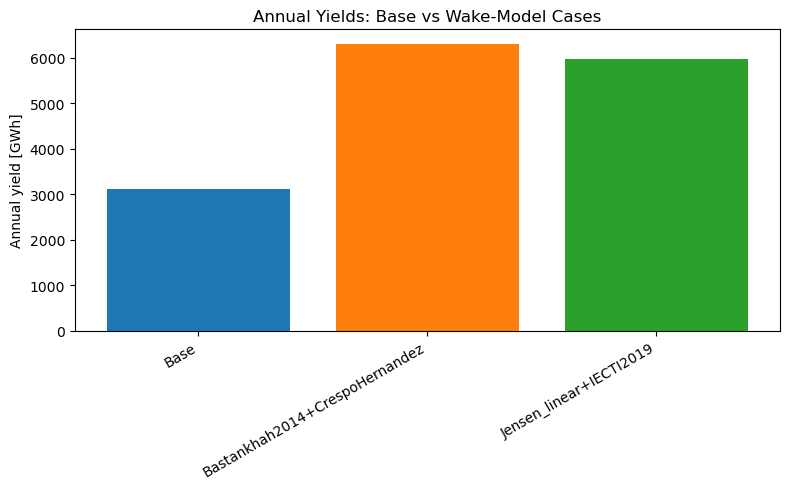

In [15]:
# %% 6) Comparative Bar Chart
labels_short = ["Base", "Bastankhah2014+CrespoHernandez", "Jensen_linear+IECTI2019"]

plt.figure(figsize=(8,5))
plt.bar(labels_short, yield_values, color=['C0', 'C1', 'C2'])
plt.ylabel("Annual yield [GWh]")
plt.title("Annual Yields: Base vs Wake-Model Cases")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


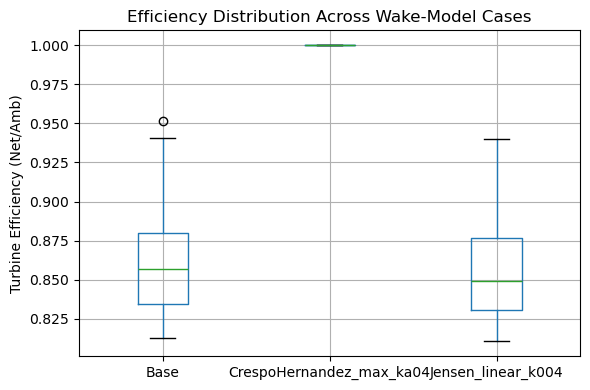

In [16]:
# %% 7) Comparative Efficiency Boxplot
eff_df = pd.DataFrame(eff_distributions)
plt.figure(figsize=(6,4))
eff_df.boxplot()
plt.ylabel("Turbine Efficiency (Net/Amb)")
plt.title("Efficiency Distribution Across Wake‐Model Cases")
plt.tight_layout()
plt.show()
